      gpa  gender_M  prog_code_BIOG  prog_code_CCOM  prog_code_CONT  \
0     273         0               1               0               0   
1     305         1               0               0               0   
2     216         1               0               0               0   
3     286         1               0               0               0   
4     276         0               1               0               0   
...   ...       ...             ...             ...             ...   
1354  261         0               0               0               0   
1355  303         1               0               0               0   
1356  306         0               1               0               0   
1357  271         1               0               0               1   
1358  313         1               0               0               1   

      prog_code_EFEE  prog_code_ESCO  prog_code_FINA  prog_code_GEMA  \
0                  0               0               0               0   
1  

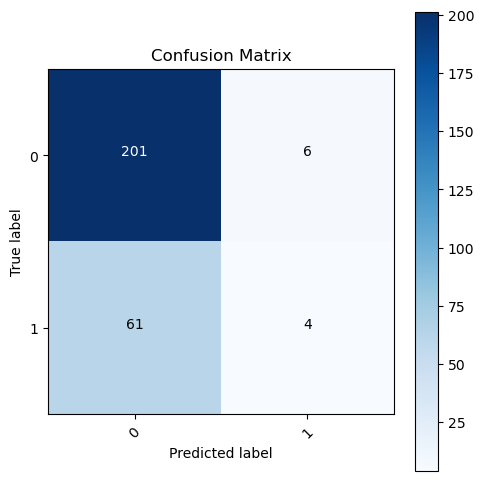

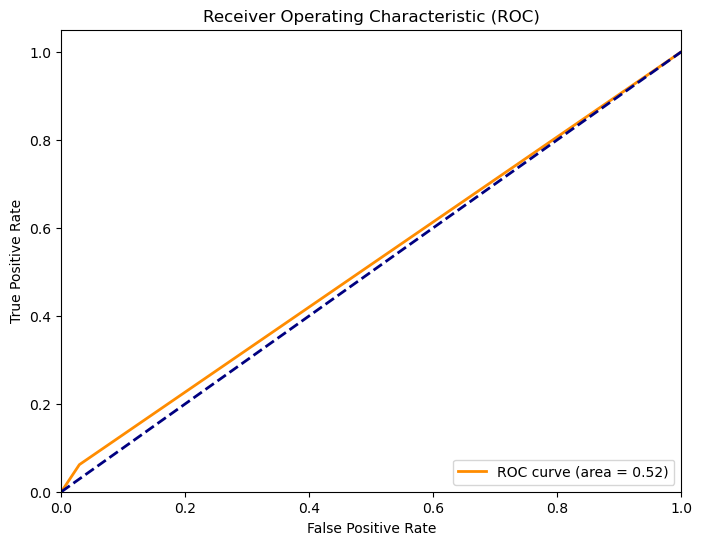

In [30]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import itertools


def load_data(file_path):
    return pd.read_csv(file_path)

def sort_data_by_column(data, column):
    return data.sort_values(by=column, ascending=True)

def filter_data(data, num_start, prog_type, year_cred):
    filtro = (
        (data['Num Est'].astype(str).str.startswith(num_start)) & 
        (data['Prog Type'] == prog_type) & 
        (data['Año Cred'].isin(year_cred))
    )
    return data[filtro]

def identify_shared_data(data1, data2, shared_data, not_shared_data):
    for index, row in data1.iterrows():
        num_est = row['Num Est']
        if num_est in data2['Num Est'].values:
            shared_data.append(row)
        else:
            not_shared_data.append(row)

def merge_dataframes(df1, df2, how):
    return pd.merge(df1, df2, how=how)


def identify_dropout(data, graduated_students):
    dropout_list = []
    for index, row in data.iterrows():
        num_est = row['Num Est']
        if num_est not in graduated_students['Num Est'].values:
            dropout_list.append(row)
    return pd.DataFrame(dropout_list)

def rename_columns(data, column_names):
    return data.rename(columns=column_names)

def select_columns(data, columns_to_keep):
    return data[columns_to_keep]

def list_to_dataframe(data):
    return pd.DataFrame(data)

def accuracy_score(y_true, y_pred):
    """
    Calculates the accuracy score between the true labels and predicted labels.
 
    Parameters:
    - y_true: array-like of shape (n_samples,)
        The true labels.
    - y_pred: array-like of shape (n_samples,)
        The predicted labels.
 
    Returns:
    - float:
        The accuracy score.
 
    Raises:
    - ValueError:
        If the lengths of y_true and y_pred are not equal.
    """
 
    # Checking if the lengths of y_true and y_pred are equal
    if len(y_true) != len(y_pred):
        raise ValueError("Lengths of y_true and y_pred should be equal.")
 
    # Counting the number of correct predictions
    correct_predictions = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
 
    # Calculating the accuracy score
    accuracy = correct_predictions / len(y_true)
 
    return accuracy

# Load data
data_2022 = load_data('student-data-2022-2023.csv')
data_2023 = load_data('student-data-2021-2022.csv')
students_graduated_2022 = sort_data_by_column(load_data('students_graduated.csv'), 'Num Est')

# Filter data
filtered_data_2022 = filter_data(data_2022, '841', 'Bachillerato', ['SEG', 'TER', 'CUA', '6TO', 'SNB', 'TNB', 'CNB', '6TN'])
filtered_data_2023 = filter_data(data_2023, '841', 'Bachillerato', ['SEG', 'TER', 'CUA', '6TO', 'SNB', 'TNB', 'CNB', '6TN'])

# Identify shared and non-shared data
shared_data = []
not_shared_data = []
identify_shared_data(filtered_data_2023, filtered_data_2022, shared_data, not_shared_data)
shared_data_df = list_to_dataframe(shared_data)
shared_data_df['dropout'] = 'N'
not_shared_data_df = list_to_dataframe(not_shared_data)

#Identify dropout
student_dropout_df = identify_dropout(not_shared_data_df, students_graduated_2022)
student_dropout_df['dropout'] = 'Y'

# Merge and select columns
training_model_data = merge_dataframes(shared_data_df, student_dropout_df, 'outer')
columns_to_keep = ['Num Est', 'Sexo', 'Prog Code', 'GPA', 'Muni', 'Año Cred', 'dropout']
training_model_data = select_columns(training_model_data, columns_to_keep)

# Rename columns
new_column_names = {
    'Num Est': 'student_id_PK',
    'Sexo': 'gender',
    'Prog Code': 'prog_code',
    'GPA': 'gpa',
    'Muni': 'town_origin',
    'Año Cred': 'year_cred',
}
training_model_data = rename_columns(training_model_data, new_column_names)

#Select the relevant columns and the objective column
features = training_model_data[['gender', 'prog_code', 'gpa', 'town_origin', 'year_cred']]
target = training_model_data['dropout']

# Create dummy variables for categorical features
features = pd.get_dummies(features, columns=['gender', 'prog_code', 'town_origin', 'year_cred'], drop_first=True)
print(features)
#target = pd.get_dummies(target, columns=['dropout'], drop_first=True)

#Training and testing set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Entrenar el modelo de regresión logística
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)

#Calculate the precision of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy * 100:.2f}%')

# Assuming you have trained a logistic regression model named 'logistic_regression_model'
# and 'features' is your feature matrix

# Get the intercept and coefficients
intercept = model.intercept_[0]
coefficients = model.coef_[0]

# Get the feature names
feature_names = features.columns

# Initialize the formula
formula = f"P(Y=1) = 1 / (1 + e^(-({intercept} + "

# Loop through coefficients and feature names to add terms to the formula
for i, (coef, feature_name) in enumerate(zip(coefficients, feature_names)):
    if i > 0:
        formula += f" + {coef:.4f}*{feature_name}"

# Complete the formula
formula += "))"
print("Logistic Formula:")
print(formula)

# Assuming y_test and y_pred are numpy arrays
y_test = np.where(y_test == 'Y', 1, 0)
y_pred = np.where(y_pred == 'Y', 1, 0)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = [0, 1]  # Assuming binary classification
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# ROC Curve
def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred)

# Plot ROC Curve
plot_roc_curve(y_test, y_pred)  # Assuming y_pred is the predicted probabilities

plt.show()

In [15]:
import numpy as np

class LogisticRegression:
    """
    Class to implement Logistic Regression without using scikit-learn library.

    Attributes:
    - learning_rate: float
        The learning rate for the logistic regression algorithm.
    - num_iterations: int
        The number of iterations for the logistic regression algorithm.
    - weights: numpy.ndarray
        The weights for the logistic regression model.
    """

    def __init__(self, learning_rate=0.01, num_iterations=1000):
        """
        Constructor to instantiate the LogisticRegression class.

        Parameters:
        - learning_rate: float, optional (default=0.01)
            The learning rate for the logistic regression algorithm.
        - num_iterations: int, optional (default=1000)
            The number of iterations for the logistic regression algorithm.
        """

        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None

    def sigmoid(self, z):
        """
        Sigmoid function to map any real-valued number to a value between 0 and 1.

        Parameters:
        - z: numpy.ndarray
            The input value(s) to the sigmoid function.

        Returns:
        - numpy.ndarray:
            The output value(s) after applying the sigmoid function.
        """

        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """
        Fit the logistic regression model to the training data.

        Parameters:
        - X: numpy.ndarray
            The input features of the training data.
        - y: numpy.ndarray
            The target values of the training data.

        Returns:
        - self:
            Returns the instance of the LogisticRegression class.
        """

        # Adding a column of ones to the input features for the bias term
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

        # Initializing the weights with zeros
        self.weights = np.zeros(X.shape[1])

        # Gradient descent optimization
        for _ in range(self.num_iterations):
            # Calculate the predicted probabilities
            y_pred = self.sigmoid(np.dot(X, self.weights))

            # Calculate the gradient
            gradient = np.dot(X.T, (y_pred - y)) / y.size

            # Update the weights
            self.weights -= self.learning_rate * gradient

        return self

    def predict(self, X):
        """
        Predict the target values for the input features.

        Parameters:
        - X: numpy.ndarray
            The input features for which to make predictions.

        Returns:
        - numpy.ndarray:
            The predicted target values.
        """

        # Adding a column of ones to the input features for the bias term
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

        # Calculate the predicted probabilities
        y_pred = self.sigmoid(np.dot(X, self.weights))

        # Round the probabilities to obtain the predicted classes
        y_pred_class = np.round(y_pred)

        return y_pred_class

# Example usage of the LogisticRegression class:

def load_data(filename):
    """
    Load the data from a CSV file.

    Parameters:
    - filename: str
        The path to the CSV file.

    Returns:
    - numpy.ndarray:
        The loaded data as a numpy array.
    """

    data = np.genfromtxt(filename, delimiter=',', skip_header=1)
    X = data[:, :-1]
    y = data[:, -1]

    return X, y

def logistic_regression_without_scikit(filename):
    """
    Perform logistic regression without using scikit-learn library.

    Parameters:
    - filename: str
        The path to the CSV file.

    Returns:
    - numpy.ndarray:
        The predicted target values.
    """

    # Load the data
    X, y = load_data(filename)

    # Create an instance of the LogisticRegression class
    model = LogisticRegression()

    # Fit the model to the training data
    model.fit(X, y)

    # Make predictions on the input features
    y_pred = model.predict(X)

    return y_pred

# Example usage of the logistic_regression_without_scikit function:
filename = "training_model_data.csv"
predictions = logistic_regression_without_scikit(filename)
print(predictions)

[nan nan nan ... nan nan nan]
